In [ ]:
# imports
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [3]:
SEED = 42 #for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# **Data Exploration**

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'xxx' #replace with kaggle usename and key
os.environ['KAGGLE_KEY'] = 'xxx'

!pip install -q kaggle
!kaggle datasets download -d drgfreeman/rockpaperscissors
!unzip -q rockpaperscissors.zip

Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
 93% 283M/306M [00:03<00:00, 60.1MB/s]
100% 306M/306M [00:03<00:00, 89.5MB/s]


In [5]:
# check the contents of the unzipped file
!ls

paper			  rock			 rps-cv-images	scissors
README_rpc-cv-images.txt  rockpaperscissors.zip  sample_data


In [6]:
# View README content
with open("README_rpc-cv-images.txt", "r") as file:
    content = file.read()
    print(content)

AUTHOR: Julien de la Bruère-Terreault (drgfreeman@tuta.io)

LICENSE: CC-BY-SA 4.0

DESCRIPTION: This dataset contains images of hand gestures from the Rock-Paper-Scissors game. The images were captured as part of a hobby project where I developped a Rock-Paper-Scissors game using computer vision and machine learning on the Raspberry Pi (https://github.com/DrGFreeman/rps-cv)

CONTENTS: The dataset contains a total of 2188 images corresponding to the 'Rock' (726 images), 'Paper' (710 images) and 'Scissors' (752 images) hand gestures of the Rock-Paper-Scissors game. All image are taken on a green background with relatively consistent ligithing and white balance.

FORMAT: All images are RGB images of 300 pixels wide by 200 pixels high in .png format. The images are separated in three sub-folders named 'rock', 'paper' and 'scissors' according to their respective class.




In [7]:
# confirming number of pictures per class
data_path = '.'  # current directory where rock, paper, scissors folders are
classes = ['rock', 'paper', 'scissors']

for i in classes:
    class_path = os.path.join(data_path, i)
    num_images = len(os.listdir(class_path))
    print(f"{i.capitalize()}: {num_images} images")

Rock: 726 images
Paper: 712 images
Scissors: 750 images


In [8]:
# confirming image size
image_shapes = []
for class_name in classes:
    folder = os.path.join(data_path, class_name)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        image_shapes.append(img.size)
        break  # just check one image per class

image_shapes

[(300, 200), (300, 200), (300, 200)]

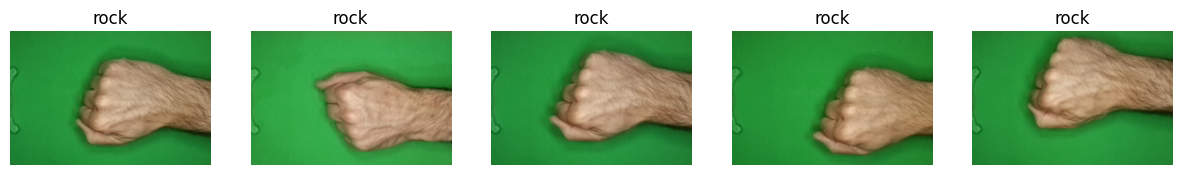

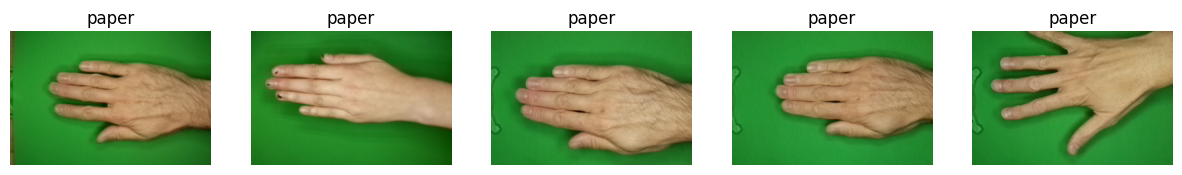

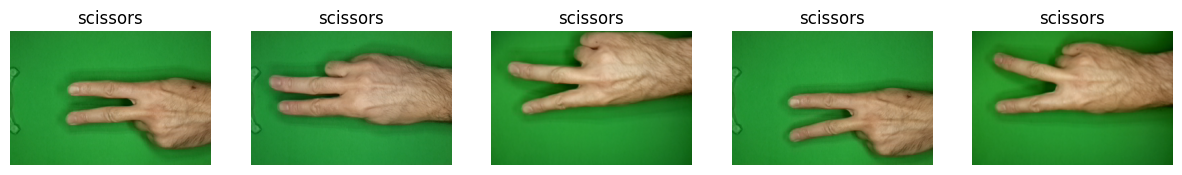

In [9]:
def show_sample_images(class_name, n=5):
    folder = os.path.join(data_path, class_name)
    images = random.sample(os.listdir(folder), n)

    plt.figure(figsize=(15,3))
    for i, img_file in enumerate(images):
        img_path = os.path.join(folder, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Show 5 sample images per class
for c in classes:
    show_sample_images(c)

# **Data Preprocessing**

In [10]:
# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
DATASET_DIR = 'rps-cv-images'
CLASSES = ['rock', 'paper', 'scissors']

# Create structured folders for train, val, test
base_dir = 'processed_rps'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for split_dir in [train_dir, val_dir, test_dir]:
    for cls in CLASSES:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Split images into train/val/test
for cls in CLASSES:
    cls_dir = os.path.join(DATASET_DIR, cls)
    images = os.listdir(cls_dir)
    images = [img for img in images if img.endswith('.png')]
    images.sort()  # ensure reproducibility
    train_imgs, test_imgs = train_test_split(images, test_size=0.15, random_state=SEED)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.176, random_state=SEED)  # 0.15/0.85 ≈ 0.176

    for img in train_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))


In [11]:
# Data generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_aug = ImageDataGenerator(rescale=1./255)

# Load data
train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_aug.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_aug.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1530 images belonging to 3 classes.
Found 329 images belonging to 3 classes.
Found 329 images belonging to 3 classes.


# **Model 1 - simple / hypertuned**

In [12]:

def build_simple_cnn(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.3):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [13]:
param_grid = {
    'learning_rates': [0.01, 0.005, 0.001],
    'dropout_rates': [0.1, 0.3, 0.5]
}

In [15]:
best_model = None
best_val_loss = float('inf')
history_dict = {}

for lr in param_grid['learning_rates']:
    for dr in param_grid['dropout_rates']:
        print(f"\nTraining with lr={lr}, dropout={dr}")

        model = build_simple_cnn(dropout_rate=dr)
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        mode='min'
       )

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=20,
            callbacks=[early_stop],
            verbose=1
        )


        final_val_loss = min(history.history['val_loss'])
        key = f"lr={lr}, dr={dr}"
        history_dict[key] = history

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = model
            best_key = key


🔍 Training with lr=0.01, dropout=0.1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3356 - loss: 9.3523 - val_accuracy: 0.3435 - val_loss: 1.0984
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 939ms/step - accuracy: 0.3573 - loss: 1.0980 - val_accuracy: 0.3435 - val_loss: 1.0984
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 876ms/step - accuracy: 0.3615 - loss: 1.0984 - val_accuracy: 0.3313 - val_loss: 1.0985
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 871ms/step - accuracy: 0.2968 - loss: 1.0990 - val_accuracy: 0.3252 - val_loss: 1.0986

🔍 Training with lr=0.01, dropout=0.3
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 855ms/step - accuracy: 0.3255 - loss: 3.9777 - val_accuracy: 0.3435 - val_loss: 1.0986
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 900ms/step - accuracy: 0.3247 - loss: 1.0992 - val_accuracy: 0.3435 - val_loss: 1.0984
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 857ms/step - accuracy: 0.3472 - loss: 1.0984 - val_accuracy: 0.3435 - val_loss: 1.0984
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accurac

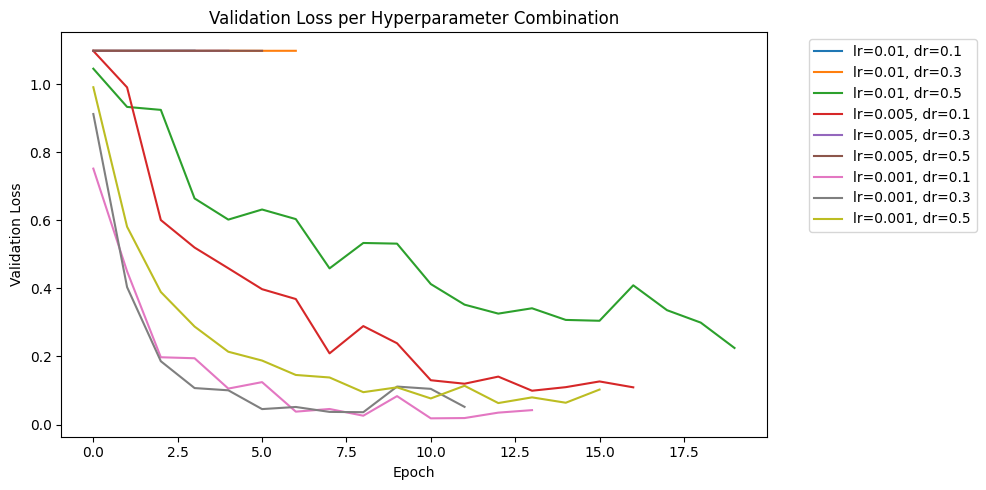

In [16]:
plt.figure(figsize=(10, 5))

for key, hist in history_dict.items():
    plt.plot(hist.history['val_loss'], label=f"{key}")

plt.title("Validation Loss per Hyperparameter Combination")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Best Model: {best_key}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and Report
y_true = test_gen.classes
y_pred_probs = best_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=CLASSES))

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.9701 - loss: 0.0621
Best Model: lr=0.001, dr=0.1
Test Accuracy: 0.9787
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
              precision    recall  f1-score   support

        rock       0.99      0.96      0.98       107
       paper       0.96      1.00      0.98       109
    scissors       0.99      0.97      0.98       113

    accuracy                           0.98       329
   macro avg       0.98      0.98      0.98       329
weighted avg       0.98      0.98      0.98       329



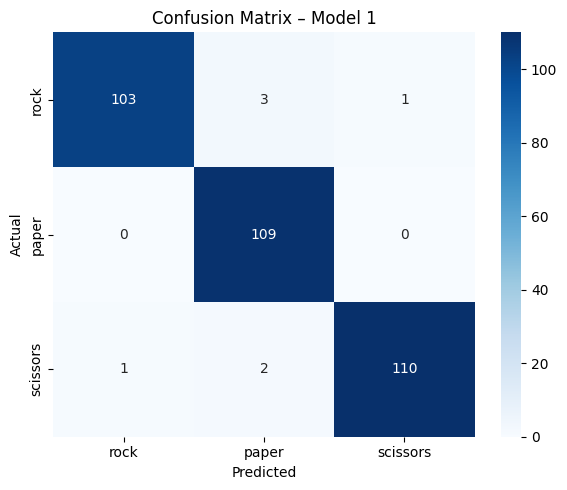

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Model 1')
plt.tight_layout()
plt.show()


# **Model 2**

In [21]:
def build_intermediate_cnn(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.3):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [22]:
model2 = build_intermediate_cnn(dropout_rate=0.3)

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.3935 - loss: 1.1466 - val_accuracy: 0.8207 - val_loss: 0.6421
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6891 - loss: 0.7419 - val_accuracy: 0.9179 - val_loss: 0.2933
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8523 - loss: 0.3925 - val_accuracy: 0.9453 - val_loss: 0.1559
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8948 - loss: 0.2804 - val_accuracy: 0.9453 - val_loss: 0.1686
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8976 - loss: 0.2689 - val_accuracy: 0.9544 - val_loss: 0.1333
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9215 - loss: 0.2376 - val_accuracy: 0.9666 - val_loss: 0.1063
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9352 - loss: 0.1997 - val_accuracy: 0.9635 - val_loss: 0.1138
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9216 - loss: 0.2117 - val_accuracy: 0.9787 - val_loss:

In [23]:
test_loss2, test_acc2 = model2.evaluate(test_gen)
print(f"\nModel 2 Test Accuracy: {test_acc2:.4f} | Test Loss: {test_loss2:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.9578 - loss: 0.1180

Model 2 Test Accuracy: 0.9666 | Test Loss: 0.1147


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step

Classification Report for Model 2:
              precision    recall  f1-score   support

        rock       0.95      0.95      0.95       107
       paper       0.95      0.96      0.95       109
    scissors       1.00      0.98      0.99       113

    accuracy                           0.97       329
   macro avg       0.97      0.97      0.97       329
weighted avg       0.97      0.97      0.97       329



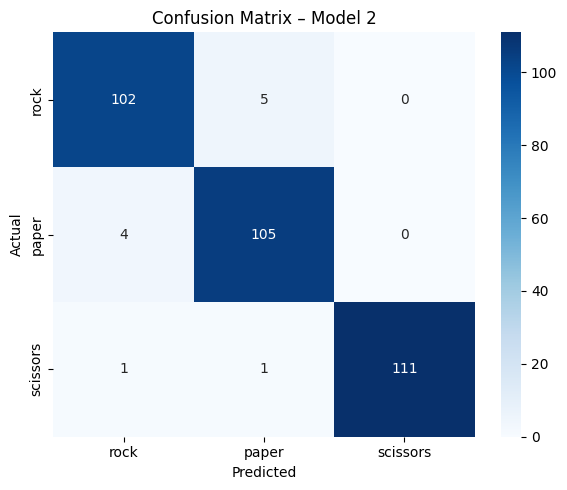

In [24]:
y_true2 = test_gen.classes
y_pred_probs2 = model2.predict(test_gen)
y_pred2 = np.argmax(y_pred_probs2, axis=1)

# Report
print("\nClassification Report for Model 2:")
print(classification_report(y_true2, y_pred2, target_names=CLASSES))

# Confusion Matrix
cm2 = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Model 2')
plt.tight_layout()
plt.show()


# **Model 3**

In [29]:
def build_deep_cnn(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.3):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [30]:
model3 = build_deep_cnn()

model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

history3 = model3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3905 - loss: 1.0937 - val_accuracy: 0.6444 - val_loss: 0.7677
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7335 - loss: 0.5959 - val_accuracy: 0.9544 - val_loss: 0.1692
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8704 - loss: 0.3492 - val_accuracy: 0.9392 - val_loss: 0.1722
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8989 - loss: 0.3023 - val_accuracy: 0.9787 - val_loss: 0.0943
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9201 - loss: 0.2276 - val_accuracy: 0.9818 - val_loss: 0.0794
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9569 - loss: 0.1589 - val_accuracy: 0.9726 - val_loss: 0.0977
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9540 - loss: 0.1571 - val_accuracy: 0.9818 - val_loss: 0.0525
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9567 - loss: 0.1538 - val_accuracy: 0.9818 - val_loss:

In [31]:
test_loss3, test_acc3 = model3.evaluate(test_gen)
print(f"\nModel 3 Test Accuracy: {test_acc3:.4f} | Test Loss: {test_loss3:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.9892 - loss: 0.0399

Model 3 Test Accuracy: 0.9848 | Test Loss: 0.0520


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step

Classification Report for Model 3:
              precision    recall  f1-score   support

        rock       0.97      0.99      0.98       107
       paper       0.98      0.99      0.99       109
    scissors       1.00      0.97      0.99       113

    accuracy                           0.98       329
   macro avg       0.98      0.98      0.98       329
weighted avg       0.99      0.98      0.98       329



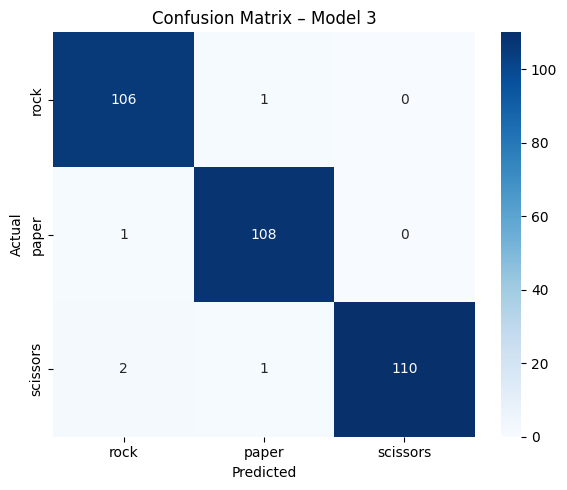

In [32]:
y_true3 = test_gen.classes
y_pred_probs3 = model3.predict(test_gen)
y_pred3 = np.argmax(y_pred_probs3, axis=1)

print("\nClassification Report for Model 3:")
print(classification_report(y_true3, y_pred3, target_names=CLASSES))

cm3 = confusion_matrix(y_true3, y_pred3)
plt.figure(figsize=(6, 5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Model 3')
plt.tight_layout()
plt.show()